# Viusal Recognition part 2 Final Project
# Team Name: SRK 
## Shubham , Rahul, Kapil

We'll be using a PyTorch implementation of an *LSTM* (Long Short Term Memory) neural network to create this image captioning model. The image input will be preprocessed with one of torchvision's pretrained model and the partial caption (truncated at mid-sentence) will be preprocessed with the *word2vec* algorithm.

Importing libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import torch
import torchvision
from PIL import Image

## Convert images to latent variables, with a pre-trained CNN
The image analysis part of the caption generator will use a pre-trained convolutional neural network. Since the pre-trained models available through torchvision were trained on ImageNet, a large database of natural scene images, we will assume that these models learned to detect the presence of the objects and the actions that we can find in the flickr8k dataset. If it is indeed the case, the latent representation of the images will contain sufficient signals to reconstruct a depicting sentence. 
Let's start by converting all the images in the dataset into their corresponding latent representation, which we'll write to file.

In [2]:
imagesFilepath = "../input/flickr8k/Flickr_Data/Flickr_Data/Images"
latent_representation_filepath = "/kaggle/working/flickr8k_latent.csv"
useCuda = torch.cuda.is_available()
# Load the googlenet pre-trained neural network
encoder = torchvision.models.googlenet(pretrained=True)
encoder.eval()
# Replace the last linear layer (called 'fc') with a dummy identity layer.
# By doing this, we can output the image latent representation
# without messing with the layers naming convention
encoder.fc = torch.nn.Identity()
number_of_latent_variables = 1024 # Can be found by examining googlenet architecture
if useCuda:
    encoder = encoder.cuda()

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


In [3]:
print(encoder)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [4]:
preprocess = torchvision.transforms.Compose([
            torchvision.transforms.Resize(256),
            torchvision.transforms.CenterCrop(224),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        

In [5]:
# Create a list of jpg image filepaths
found_jpg_filepaths = []
directory_contents = os.listdir(imagesFilepath)
for content in directory_contents:
    filepath = os.path.join(imagesFilepath, content)
    if filepath.endswith('.jpg'):
        found_jpg_filepaths.append(filepath)

In [6]:
#print(found_jpg_filepaths)

In [7]:
if not os.path.isfile(latent_representation_filepath): # No need to run it more than once
    with open(latent_representation_filepath, 'w+') as output_file:
        # Write the file header
        output_file.write('filepath')
        for variableNdx in range(number_of_latent_variables):
            output_file.write(",v{}".format(variableNdx))
        output_file.write("\n")

        # Loop through the images
        for index, image_filepath in enumerate(found_jpg_filepaths):
            output_file.write(image_filepath)
            image = Image.open(image_filepath)
            inputTsr = preprocess(image).unsqueeze(0) # Preprocess and add a dummy mini-batch dimension
            if useCuda:
                inputTsr = inputTsr.cuda()
            with torch.no_grad():
                latentTsr = encoder(inputTsr)[0] # Run a forward pass through the encoder and get rid of the dummy mini-batch dimension
                for valueNdx in range(latentTsr.shape[-1]):
                    output_file.write(",{}".format(latentTsr[valueNdx].item()))
                output_file.write("\n")
            if index % 300 == 0:
                print ("{}/{}".format(index, len(found_jpg_filepaths)), end=" ", flush=True)


0/8091 300/8091 600/8091 900/8091 1200/8091 1500/8091 1800/8091 2100/8091 2400/8091 2700/8091 3000/8091 3300/8091 3600/8091 3900/8091 4200/8091 4500/8091 4800/8091 5100/8091 5400/8091 5700/8091 6000/8091 6300/8091 6600/8091 6900/8091 7200/8091 7500/8091 7800/8091 

In [8]:
latent_representationDf = pd.read_csv(latent_representation_filepath)

## Create the dataset vocabulary
The set of words used in the training dataset will be the vocabulary that our caption generator will be allowed to use. 
Let's check the dataset captions structure.

In [9]:
descriptions_filepath = '../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
!head $descriptions_filepath
sample_filename = os.path.basename(found_jpg_filepaths[10])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .


In [10]:
print(sample_filename)

3351493005_6e5030f596.jpg


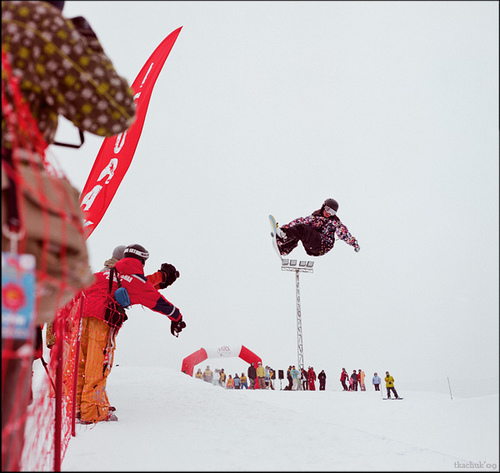

In [11]:
sample_image_filename = '3351493005_6e5030f596.jpg'
import IPython.display
IPython.display.Image(os.path.join(imagesFilepath, sample_image_filename))

We can see that the file '.../Flickr8k.token.txt' contains, on each line, the filename of an image appended with '#X' (X being a number between 0 and 4, presumably representing various human annotators who wrote the description), followed by the description.
There is another pair of files that we'll need to split the training images and the validation images (referred to as 'dev' by the dataset).

In [12]:
training_images_filepath = '../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
validation_images_filepath = '../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
!head $training_images_filepath

2513260012_03d33305cf.jpg
2903617548_d3e38d7f88.jpg
3338291921_fe7ae0c8f8.jpg
488416045_1c6d903fe0.jpg
2644326817_8f45080b87.jpg
218342358_1755a9cce1.jpg
2501968935_02f2cd8079.jpg
2699342860_5288e203ea.jpg
2638369467_8fc251595b.jpg
2926786902_815a99a154.jpg


These two files give a list of filenames, partitioning the dataset into training and validations sets.
Let's build a dictionary of each word in the training set to their corresponding number of occurrences. The following function Tokenize() will convert a description such as 'A child eats an apple .' into a list of lowercase tokens such as ['a', 'child', 'eats', 'an', 'apple'].

In [13]:
import en_core_web_sm
import re
import string

nlp = en_core_web_sm.load()

def Tokenize(text, nlp):
    text = re.sub(r"[^\x00-\x7F]+", " ", text)
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')  # Remove punctuation and numbers
    nopunct = regex.sub(" ", text.lower())
    tokens = [token.text for token in nlp.tokenizer(nopunct) if not token.text.isspace()]
    return tokens

def TrainDescriptionTokens(descriptions_filepath, train_images_list, nlp):
    number_of_train_lines = 0
    number_of_not_train_lines = 0
    train_token_to_occurrences_dict = {}
    with open(descriptions_filepath, 'r') as descriptions_file:
        for line in descriptions_file:
            line = line.strip()
            sharp_index = line.find('#')
            if sharp_index == -1:
                raise ValueError("TrainDescriptionTokens(): Could not find '#' in line '{}'".format(line))
            image_filename = line[:sharp_index]
            description = line[sharp_index + 3: ]
            if image_filename in train_images_list:
                # Tokenize the description
                tokens = Tokenize(description, nlp)
                for token in tokens:
                    if token in train_token_to_occurrences_dict:
                        train_token_to_occurrences_dict[token] += 1
                    else:
                        train_token_to_occurrences_dict[token] = 1
                number_of_train_lines += 1
            else:
                number_of_not_train_lines += 1
    print("TrainDescriptionTokens(): number_of_train_lines = {}; number_of_not_train_lines = {}".format(number_of_train_lines, number_of_not_train_lines))
    return train_token_to_occurrences_dict

with open(training_images_filepath, 'r') as train_images_file:
    train_images_list = [line.strip() for line in train_images_file]
train_token_to_occurrences_dict = TrainDescriptionTokens(descriptions_filepath,
                                                             train_images_list, nlp)

TrainDescriptionTokens(): number_of_train_lines = 30000; number_of_not_train_lines = 10460


The raw dictionary that was just created contains more than 7000 words, but some of them only appear once. These are either very rare words or possibly misspelled words. For these reasons, we want to get rid of the words that appear only once in the dataset.

In [14]:
print("Before filtering the single occurrences, len(train_token_to_occurrences_dict) = {}".format(len(train_token_to_occurrences_dict)))
single_occurrence_words = []
for word, occurrences in train_token_to_occurrences_dict.items():
    if occurrences < 2:
        single_occurrence_words.append(word)
for word in single_occurrence_words:
    train_token_to_occurrences_dict.pop(word)
print("After filtering the single occurrences, len(train_token_to_occurrences_dict) = {}".format(len(train_token_to_occurrences_dict)))

Before filtering the single occurrences, len(train_token_to_occurrences_dict) = 7331
After filtering the single occurrences, len(train_token_to_occurrences_dict) = 4427


We could remove almost 3000 words that appeared only once in the vocabulary.
Let's sort the words in reverse order of frequency and write our vocabulary to file. We'll also need three special words that we'll put at the beginning of the vocabulary.

In [15]:
vocabulary_filepath = '/kaggle/working/vocabulary.csv'
sorted_tokens = sorted(train_token_to_occurrences_dict.items(),
                           key=lambda x: x[1], reverse=True) # Cf. https://careerkarma.com/blog/python-sort-a-dictionary-by-value/
sorted_tokens = [('ENDOFSEQ', 0), ('UNKNOWN', 0), ('NOTSET', 0)] + sorted_tokens

with open(vocabulary_filepath, 'w+') as output_file:
    output_file.write("index,word,frequency\n")
    for index, token in enumerate(sorted_tokens):
        output_file.write("{},{},{}\n".format(index, token[0], token[1]))

## Pre-tokenize the descriptions
In order to accelerate the training process, we'll convert the descriptions into their tokenized version, using the index attributed to each word that we saved in the vocabulary file.

In [16]:
def LoadVocabulary(vocabularyFilepath):
    word_to_index_dict = {}
    index_to_word_dict = {}
    vocabDf = pd.read_csv(vocabularyFilepath)
    for i, row in vocabDf.iterrows():
        index = row['index']
        word = row['word']
        word_to_index_dict[word] = index
        index_to_word_dict[index] = word
    return word_to_index_dict, index_to_word_dict

word_to_index_dict, index_to_word_dict = LoadVocabulary(vocabulary_filepath)
print ("word_to_index_dict['apple'] = {}".format(word_to_index_dict['apple']))

def ConvertTokensListToIndices(tokens, word_to_index_dict, maximum_length):
    indices = [word_to_index_dict['NOTSET']] * maximum_length
    for tokenNdx, token in enumerate(tokens):
        index = word_to_index_dict.get(token, word_to_index_dict['UNKNOWN']) # If the word is not in the dictionary, fall back to 'UNKOWN'
        indices[tokenNdx] = index
    if len(tokens) < maximum_length:
        indices[len(tokens)] = word_to_index_dict['ENDOFSEQ']
    return indices

pretokenized_descriptions_filepath = '/kaggle/working/tokenized_descriptions.csv'
description_maximum_length = 40
with open(pretokenized_descriptions_filepath, 'w+') as outputFile:
    # Write the header
    outputFile.write("image")
    for wordNdx in range(description_maximum_length):
        outputFile.write(",w{}".format(wordNdx))
    outputFile.write("\n")

    # Loop through the lines of the descriptions file
    with open(descriptions_filepath, 'r') as descriptionsFile:
        for line in descriptionsFile:
            line = line.strip()
            sharp_index = line.find('#')
            if sharp_index == -1:
                raise ValueError("Could not find '#' in line '{}'".format(line))
            image_filename = line[:sharp_index]
            description = line[sharp_index + 3:]
            # Tokenize the description
            tokens = Tokenize(description, nlp)

            # Convert the list of tokens to a list of indices
            indices = ConvertTokensListToIndices(tokens,
                                                 word_to_index_dict,
                                                 description_maximum_length)
            outputFile.write(image_filename)
            for indexNdx in range(len(indices)):
                outputFile.write(",{}".format(indices[indexNdx]))
            outputFile.write("\n")

word_to_index_dict['apple'] = 1648


In [17]:
tokenized_descriptionsDf = pd.read_csv(pretokenized_descriptions_filepath)
tokenized_descriptionsDf.head()

,image,w0,w1,w2,w3,w4,w5,w6,w7,w8,...,w30,w31,w32,w33,w34,w35,w36,w37,w38,w39
0,1000268201_693b08cb0e.jpg,3,43,4,3,88,172,7,117,53,...,2,2,2,2,2,2,2,2,2,2
1,1000268201_693b08cb0e.jpg,3,19,316,65,3,197,120,0,2,...,2,2,2,2,2,2,2,2,2,2
2,1000268201_693b08cb0e.jpg,3,40,19,117,65,3,197,2069,0,...,2,2,2,2,2,2,2,2,2,2
3,1000268201_693b08cb0e.jpg,3,40,19,117,5,397,20,61,2069,...,2,2,2,2,2,2,2,2,2,2
4,1000268201_693b08cb0e.jpg,3,40,19,4,3,88,172,316,65,...,2,2,2,2,2,2,2,2,2,2


We now have our descriptions in the form of a list of integers. If their length is less than the set maximum length (40), they will end with the special index 0 meaning 'ENDOFSEQ', followed by a padding of the special index 2 meaning 'NOTSET'. If a word is not in the vocabulary (i.e. the word is one of those that we threw away because they appeared only once), it will be replaced by the special index 1, meaning 'UNKNOWN'.
Note that each image filename will appear in 5 lines, since each image has 5 different descriptions.

## Create a word embedding with the word2vec (Continuous Bag of Words) algorithm
Encoding the words with an arbitrary index from a vocabulary dictionary is easy, but it comes with a cost. To translate this encoding into a tensor form would yield to a one-hot encoding, where each word would be represented by a sparse vector of length V (the vocabulary size) having a single entry set to 1, all the other entries being 0. Such a representation doesn't exploit the semantic of the words.  For example, verbs such as *to walk* and *to run* can often be swapped in a sentence. This will slightly affect the meaning of the sentence, but it won't destroy the sentence syntax, nor create confusing gibberish. It would be advantageous to have an encoding that represents words as numerical vectors that transpose word meaning similarities into vector similarities. This is achieved by a word embedding called [**word2vec**](https://en.wikipedia.org/wiki/Word2vec). We'll implement the Continuous Bag of Words (CBOW) variant.

In [18]:
training_description_indices = []
for t in tokenized_descriptionsDf.itertuples():
    filename = t[1]
    if filename in train_images_list:
        training_description_indices.append(list(t[2:]))
print ("training_description_indices[0:5] = {}".format(training_description_indices[0:5]))

training_description_indices[0:5] = [[3, 43, 4, 3, 88, 172, 7, 117, 53, 3, 390, 12, 397, 4, 28, 1, 629, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 19, 316, 65, 3, 197, 120, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 40, 19, 117, 65, 3, 197, 2069, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 40, 19, 117, 5, 397, 20, 61, 2069, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], [3, 40, 19, 4, 3, 88, 172, 316, 65, 3, 197, 2911, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]]


The word2vec (CBOW) is a self-supervised learning algorithm that aims to predict a center word, given the context words, i.e. the few words before and after the center word, in no particular order (hence the *bag of words* part in the CBOW name). For example, from the sentence 'A red apple is falling from the tree', we could sample the context bag of words ('from', 'is', 'the', 'apple') and the center word 'falling', assuming a context length of 2. 
Let's create a PyTorch Dataset that will automatically generate context words and center word from a list of sentences.

In [19]:
from torch.utils.data import Dataset, DataLoader
import random

class ContextToWordDataset(Dataset):
    def __init__(self,
                 training_descriptions_indices,
                 index_to_word_dict,
                 word_to_index_dict,
                 contextLength):
        self.training_descriptions_indices = training_descriptions_indices
        self.index_to_word_dict = index_to_word_dict
        self.word_to_index_dict = word_to_index_dict
        self.contextLength = contextLength

    def __len__(self):
        return len(self.training_descriptions_indices)

    def __getitem__(self, idx):
        description_indices = self.training_descriptions_indices[idx]
        # Randomly select a target word
        last_acceptable_center_index = len(description_indices) - 1
        if self.word_to_index_dict['ENDOFSEQ'] in description_indices:
            for position, index in enumerate(description_indices):
                if index == self.word_to_index_dict['ENDOFSEQ'] in description_indices:
                    last_acceptable_center_index = position        
        targetNdx = random.choice(range(last_acceptable_center_index + 1))
        # Create a Long tensor with dim (2 * context_length)
        description_indicesTsr = torch.ones((2 * self.contextLength)).long() * self.word_to_index_dict['NOTSET']

        runningNdx = targetNdx - int(self.contextLength)
        counter = 0
        while counter < 2 * self.contextLength:
            if runningNdx != targetNdx:
                if runningNdx >= 0 and runningNdx < len(description_indices):
                    description_indicesTsr[counter] = description_indices[runningNdx]
                counter += 1
            runningNdx += 1
        return (description_indicesTsr, description_indices[targetNdx])
    
train_dataset = ContextToWordDataset(training_description_indices,
                 index_to_word_dict,
                 word_to_index_dict,
                 contextLength=3)

In [20]:
sample_data_0 = train_dataset[0]
sample_words_0 = [index_to_word_dict[i] for i in sample_data_0[0].tolist()]
center_word_0 = index_to_word_dict[sample_data_0[1]]
print ("sample_words_0 = {}; center_word_0 = {}".format(sample_words_0, center_word_0))
sample_data_1 = train_dataset[1]
sample_words_1 = [index_to_word_dict[i] for i in sample_data_1[0].tolist()]
center_word_1 = index_to_word_dict[sample_data_1[1]]
print ("sample_words_1 = {}; center_word_1 = {}".format(sample_words_1, center_word_1))

sample_words_0 = ['is', 'climbing', 'up', 'set', 'of', 'stairs']; center_word_0 = a
sample_words_1 = ['going', 'into', 'a', 'building', 'ENDOFSEQ', 'NOTSET']; center_word_1 = wooden


We now need to create a simple PyTorch model that predicts the center word from the context words. The ordering of the context words is shuffled by an averaging operation.

In [21]:
class CenterWordPredictor(torch.nn.Module):
    def __init__(self, vocabulary_size, embedding_dimension):
        super(CenterWordPredictor, self).__init__()
        self.embedding = torch.nn.Embedding(vocabulary_size, embedding_dimension)
        self.decoderLinear = torch.nn.Linear(embedding_dimension, vocabulary_size)

    def forward(self, contextTsr):
        # contextTsr.shape = (N, context_length), contextTsr.dtype = torch.int64
        embedding = self.embedding(contextTsr)  # (N, context_length, embedding_dimension)
        # Average over context words: (N, context_length, embedding_dimension) -> (N, embedding_dimension)
        embedding = torch.mean(embedding, dim=1)

        # Decoding
        outputTsr = self.decoderLinear(embedding)
        return outputTsr
    
embedding_dimension = 128
word_embedder = CenterWordPredictor(len(word_to_index_dict), embedding_dimension)
if useCuda:
    word_embedder = word_embedder.cuda()

We can now train the word embedder.

In [22]:
word_embedder_parameters = filter(lambda p: p.requires_grad, word_embedder.parameters())
optimizer = torch.optim.Adam(word_embedder_parameters, lr=0.0001)
lossFcn = torch.nn.CrossEntropyLoss()
train_dataLoader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(1, 1000):
    word_embedder.train()
    loss_sum = 0.0
    number_of_batches = 0
    for (description_indicesTsr, target_center_word_ndx) in train_dataLoader:
        if number_of_batches % 20 == 1:
            print (".", end="", flush=True)
        if useCuda:
            description_indicesTsr = description_indicesTsr.cuda()
            target_center_word_ndx = target_center_word_ndx.cuda()
        predicted_center_word_ndx = word_embedder(description_indicesTsr)
        optimizer.zero_grad()
        loss = lossFcn(predicted_center_word_ndx, target_center_word_ndx)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        number_of_batches += 1
    train_loss = loss_sum/number_of_batches
    print ("\nepoch {}: train_loss = {}".format(epoch, train_loss))

...............................................
epoch 1: train_loss = 7.315224256088484
...............................................
epoch 2: train_loss = 5.879839090904447
...............................................
epoch 3: train_loss = 5.393007623869727
...............................................
epoch 4: train_loss = 5.196849344381645
...............................................
epoch 5: train_loss = 5.046027098891577
...............................................
epoch 6: train_loss = 4.950987342832439
...............................................
epoch 7: train_loss = 4.890854345201683
...............................................
epoch 8: train_loss = 4.843755192085624
...............................................
epoch 9: train_loss = 4.746340152551371
...............................................
epoch 10: train_loss = 4.69538384739524
...............................................
epoch 11: train_loss = 4.648340826858082
...............................

The word embedding is the weights matrix stored in the encoder embedding layer. Let's write that to disk.

In [23]:
words2vec_dictionary_filepath = '/kaggle/working/words2vec.csv'
with open(words2vec_dictionary_filepath, 'w+') as word2vecFile:
        # Write the header
        word2vecFile.write("word")
        for embeddingNdx in range(embedding_dimension):
            word2vecFile.write(",e{}".format(embeddingNdx))
        word2vecFile.write("\n")

        for index, word in index_to_word_dict.items():
            wordEmbeddingList = word_embedder.embedding.weight[index].tolist()
            word2vecFile.write(word)
            for coef in wordEmbeddingList:
                word2vecFile.write(",{}".format(str(coef)))
            word2vecFile.write("\n")

We can check a few embedding vectors.

In [24]:
word2vecDf = pd.read_csv(words2vec_dictionary_filepath)
word_to_embedding_dict = {word2vecDf.iloc[i]['word'] : word2vecDf.loc[i, 'e0': 'e{}'.format(embedding_dimension - 1)].tolist()
                              for i in range(len(word2vecDf))}

In [25]:
print ("word_to_embedding_dict['dog'] = {}".format(word_to_embedding_dict['dog']))
print()
print ("word_to_embedding_dict['dance'] = {}".format(word_to_embedding_dict['dance']))

word_to_embedding_dict['dog'] = [-0.8972716331481934, -0.7682745456695557, -1.484186768531799, -2.214097261428833, -1.069843888282776, 2.140343427658081, 0.8692380785942078, -0.08106023073196411, -1.3263510465621948, -1.463625431060791, 3.725835084915161, 0.6507065892219543, 2.066694021224976, 1.247795581817627, -3.1196837425231934, -0.2345312684774399, -3.294185876846313, 0.13651888072490692, -4.497407913208008, 0.023058941587805748, -0.3207866847515106, -0.03273101896047592, -2.1570274829864498, 1.8540692329406736, -1.058743596076965, -1.436530351638794, 2.6788251399993896, -1.2767789363861084, 0.2416061758995056, 1.4239588975906372, 1.3074449300765991, -0.6526626944541931, -2.978264570236206, 0.8301442265510559, 0.9694204330444336, -0.2803977429866791, 0.5474246740341187, 3.967072010040283, 2.193156719207764, 0.31017518043518066, 1.0690628290176392, 1.0357728004455566, -1.4266406297683716, 0.6831297278404236, -4.416457176208496, 0.3561482131481171, -2.9318692684173584, -0.7751748561

## Training an LSTM neural network
We have all the ingredients at hand to train a simple LSTM that will take as inputs the latent representation of an image and the beginning of a caption that describes this image, and that will produce as an output the next word in the caption. 
For example, let's say we have the following image:

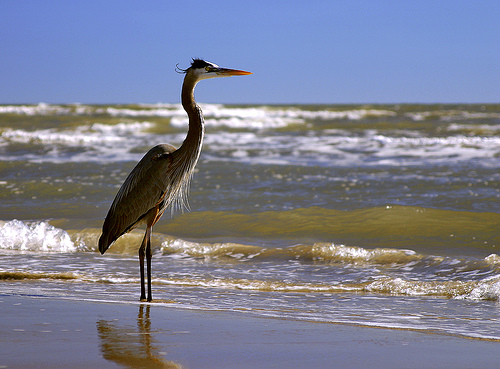

In [26]:
sample_image_filename = '99679241_adc853a5c0.jpg'
IPython.display.Image(os.path.join(imagesFilepath, sample_image_filename))

Let's say we have already predicted the beginning of the caption: *'a large bird stands in the water on the'*. The task of the LSTM, given the image latent representation and the beginning of the caption, will be to output the most likely following word. In this case, it would be *beach*.
Let's create a Dataset class.

In [27]:
class CaptionGenerationDataset(Dataset):
    def __init__(self,
                 image_filenames,
                 image_filename_to_latent_variables,
                 image_filename_to_tokenized_descriptions_list,
                 endOfSeqIndex,
                 notSetIndex,
                 vocabulary_size,
                 index_to_word_dict,
                 word_to_embedding_dict
                 ):
        self.image_filenames = image_filenames
        self.image_filename_to_latent_variables = image_filename_to_latent_variables
        self.image_filename_to_tokenized_descriptions_list = image_filename_to_tokenized_descriptions_list
        self.endOfSeqIndex = endOfSeqIndex
        self.notSetIndex = notSetIndex
        self.vocabulary_size = vocabulary_size
        self.index_to_word_dict = index_to_word_dict
        self.word_to_embedding_dict = word_to_embedding_dict

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        if idx >= len(self.image_filenames):
            raise IndexError("CaptionGenerationDataset.__getitem__(): Index {} is greater than the number of images ({})".format(idx, len(self.image_filenames)))
        filename = self.image_filenames[idx]
        latent_variables = self.image_filename_to_latent_variables[filename]
        # Build a tensor
        latent_variablesTsr = torch.zeros(len(latent_variables))
        for i in range(len(latent_variables)):
            latent_variablesTsr[i] = latent_variables[i]
        # Randomly choose one of the descriptions
        description = random.choice(self.image_filename_to_tokenized_descriptions_list[filename])
        lastIndex = self.IndexOfEndOfSeq(description)
        chopIndex = random.randint(0, lastIndex) - 1 # The last index of the chopped description
        choppedDescription = [self.notSetIndex] * len(description)
        if chopIndex >= 0:
            for i in range(chopIndex + 1):
                choppedDescription[i] = description[i]

        embedding_dim = len(self.word_to_embedding_dict[ self.index_to_word_dict[0] ]) # Length of the embedding of the 1st word
        embeddedChoppedDescriptionTsr = torch.zeros((len(description), embedding_dim))
        for wordPosn in range(len(choppedDescription)):
            embedding = self.word_to_embedding_dict[ self.index_to_word_dict[choppedDescription[wordPosn]]]
            embeddedChoppedDescriptionTsr[wordPosn] = torch.tensor(embedding)

        next_word_index = description[chopIndex + 1]

        return ( (latent_variablesTsr, embeddedChoppedDescriptionTsr), next_word_index)

    def IndexOfEndOfSeq(self, description_list):
        foundIndex = -1
        for candidateNdx in range(len(description_list)):
            if description_list[candidateNdx] == self.endOfSeqIndex:
                foundIndex = candidateNdx
                break
        if foundIndex == -1:
            return len(description_list) - 1
        else:
            return foundIndex
        
def ImageFilenameToLatentVariables(latent_varDf):
    image_filename_to_latent_variables = {}
    for i, row in latent_varDf.iterrows():
        filepath = latent_varDf.iloc[i][0]
        filename = os.path.basename(filepath)
        latent_variables = list(latent_varDf.iloc[i][1:])
        image_filename_to_latent_variables[filename] = latent_variables
    return image_filename_to_latent_variables

image_filename_to_latent_variables = ImageFilenameToLatentVariables(latent_representationDf)

def ImageFilenameToTokenizedDescriptionsList(descriptionsDF):
    image_filename_to_tokenized_description = {}
    for i, row in descriptionsDF.iterrows():
        filename = descriptionsDF.iloc[i][0]
        tokenized_description = list(descriptionsDF.iloc[i][1:])
        if filename in image_filename_to_tokenized_description:
            image_filename_to_tokenized_description[filename].append(tokenized_description)
        else:
            image_filename_to_tokenized_description[filename] = [tokenized_description]
    return image_filename_to_tokenized_description

image_filename_to_tokenized_descriptions_list = ImageFilenameToTokenizedDescriptionsList(
tokenized_descriptionsDf)

lstm_train_dataset = CaptionGenerationDataset(
        train_images_list,
        image_filename_to_latent_variables,
        image_filename_to_tokenized_descriptions_list,
        word_to_index_dict['ENDOFSEQ'],
        word_to_index_dict['NOTSET'],
        len(word_to_index_dict),
        index_to_word_dict,
        word_to_embedding_dict
    )


In [28]:
with open(validation_images_filepath, 'r') as valid_images_file:
    validation_images_list = [line.strip() for line in valid_images_file]
lstm_validation_dataset = CaptionGenerationDataset(
        validation_images_list,
        image_filename_to_latent_variables,
        image_filename_to_tokenized_descriptions_list,
        word_to_index_dict['ENDOFSEQ'],
        word_to_index_dict['NOTSET'],
        len(word_to_index_dict),
        index_to_word_dict,
        word_to_embedding_dict
    )

We'll define a simple LSTM model.

In [29]:
class LSTM_fixed_embedding(torch.nn.Module):
    def __init__(self, embedding_dim, lstm_hidden_dim,
                 num_lstm_layers, image_latent_dim,
                 vocab_size,
                 dropoutProportion=0.5):
        super(LSTM_fixed_embedding, self).__init__()
        self.embedding_dim = embedding_dim
        self.lstm = torch.nn.LSTM(embedding_dim, lstm_hidden_dim, num_lstm_layers,
                                  batch_first=True)
        self.dropout = torch.nn.Dropout(dropoutProportion)
        self.linear = torch.nn.Linear(lstm_hidden_dim + image_latent_dim, vocab_size)


    def forward(self, image_latentTsr, embeddedChoppedDescriptionTsr):
        # image_latentTsr.shape = (N, image_latent_dim)
        # embeddedChoppedDescriptionTsr.shape = (N, sequence_length, embedding_dim)
        aggregated_h, (ht, ct) = self.lstm(embeddedChoppedDescriptionTsr)
        # ht.shape = (num_lstm_layers, N, lstm_hidden_dim)
        # ht[-1].shape = (N, lstm_hidden_dim)
        concat_latent = torch.cat( (torch.nn.functional.normalize(ht[-1]),
                                    torch.nn.functional.normalize(image_latentTsr)), dim=1)
        # concat_latent.shape = (N, image_latent_dim + lstm_hidden_dim)
        outputTsr = self.linear(self.dropout(concat_latent))
        # outputTsr.shape = (N, vocab_size)
        return outputTsr

    def Caption(self, latentVariablesTsr, maximumLength,
                         word_to_embedding_dict, index_to_word_dict,
                         endOfSeqIndex, useCuda):
        notSetEmbedding = word_to_embedding_dict['NOTSET']
        embeddedChoppedDescriptionTsr = torch.zeros((maximumLength, self.embedding_dim))
        for i in range(maximumLength):
            embeddedChoppedDescriptionTsr[i] = torch.tensor(notSetEmbedding)
        endOfSeqIsFound = False
        runningNdx = 0
        caption_words = []
        while not endOfSeqIsFound and runningNdx < maximumLength:
            if useCuda:
                latentVariablesTsr = latentVariablesTsr.cuda()
                embeddedChoppedDescriptionTsr = embeddedChoppedDescriptionTsr.cuda()
            outputTsr = self.forward(latentVariablesTsr.unsqueeze(0), embeddedChoppedDescriptionTsr.unsqueeze(0))
            next_word_index = torch.argmax(outputTsr[0]).item()
            caption_words.append(index_to_word_dict[next_word_index])
            next_word = index_to_word_dict[next_word_index]
            embeddedChoppedDescriptionTsr[runningNdx] = torch.tensor(word_to_embedding_dict[next_word])
            runningNdx += 1
            if next_word_index == endOfSeqIndex:
                endOfSeqIsFound = True
        return caption_words

lstm_hidden_dimension = 32
lstm_number_of_layers = 2
dropoutProportion = 0.5
lstm_model = LSTM_fixed_embedding(
        embedding_dim=embedding_dimension,
        lstm_hidden_dim=lstm_hidden_dimension,
        num_lstm_layers=lstm_number_of_layers,
        image_latent_dim=number_of_latent_variables,
        vocab_size=len(word_to_index_dict),
        dropoutProportion=dropoutProportion
    )

if useCuda:
    lstm_model = lstm_model.cuda()

And now the LSTM training loop!
As a sanity check, we'll monitor the caption generated for two validation images. This should give us a qualitative idea of what the LSTM model is learning.

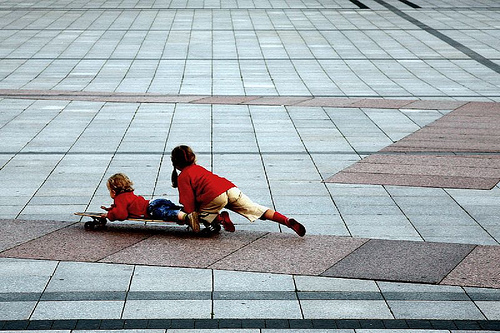

In [30]:
def TestSample(index, validation_images_list, image_filename_to_latent_variables, model,
               index_to_word_dict,
               word_to_embedding_dict,
               sequence_length=40,
               endOfSeqIndex=0,
               useCuda=True):
    sample_filename = validation_images_list[index]
    sample_latentVariablesTsr = torch.FloatTensor(image_filename_to_latent_variables[sample_filename])
    if useCuda:
        sample_latentVariablesTsr = sample_latentVariablesTsr.cuda()
    sample_words = model.Caption(
        latentVariablesTsr=sample_latentVariablesTsr,
        maximumLength=sequence_length,
        word_to_embedding_dict=word_to_embedding_dict,
        index_to_word_dict=index_to_word_dict,
        endOfSeqIndex=endOfSeqIndex,
        useCuda=useCuda
    )
    return sample_words

validation_sample_0_Ndx = 0
validation_sample_100_Ndx = 100
IPython.display.Image(os.path.join(imagesFilepath, validation_images_list[validation_sample_0_Ndx]))

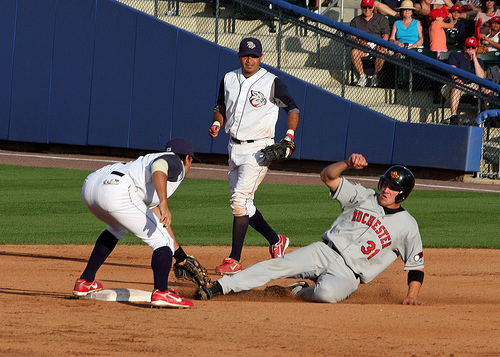

In [31]:
IPython.display.Image(os.path.join(imagesFilepath, validation_images_list[validation_sample_100_Ndx]))

We'll have to be patient... Before we get an actual meaningful sentence, the training loop will go through hundreds of epochs.
If automatic caption generation was easy, we wouldn't be doing it!

In [32]:
import sys

parameters = filter(lambda p: p.requires_grad, lstm_model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.0003)
lossFcn = torch.nn.CrossEntropyLoss()
train_dataLoader = DataLoader(lstm_train_dataset, batch_size=16, shuffle=True)
validation_dataLoader = DataLoader(lstm_validation_dataset, batch_size=lstm_validation_dataset.__len__())
best_model_filepath = '/kaggle/working/lstm.pth'

lowestValidationLoss = sys.float_info.max
for epoch in range(1, 500 + 1):
    lstm_model.train()
    loss_sum = 0.0
    numberOfBatches = 0
    for ( (latent_variablesTsr, chopped_descriptionTsr), target_next_word) in train_dataLoader:
        if numberOfBatches % 4 == 1:
            print (".", end="", flush=True)
        if useCuda:
            latent_variablesTsr = latent_variablesTsr.cuda()
            chopped_descriptionTsr = chopped_descriptionTsr.cuda()
            target_next_word = target_next_word.cuda()
        predicted_next_word = lstm_model(latent_variablesTsr, chopped_descriptionTsr)
        optimizer.zero_grad()
        loss = lossFcn(predicted_next_word, target_next_word)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        numberOfBatches += 1
    train_loss = loss_sum/numberOfBatches
    print ("\nepoch {}: train_loss = {}".format(epoch, train_loss))

    # Validation
    lstm_model.eval()
    sample_0_words = TestSample(validation_sample_0_Ndx, validation_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    print ("sample_0_words = {}".format(sample_0_words))
    sample_100_words = TestSample(validation_sample_100_Ndx, validation_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda)
    print ("sample_100_words = {}".format(sample_100_words))
    
    for ((validation_latent_variablesTsr, validation_chopped_descriptionTsr), validation_target_next_word) in validation_dataLoader:
        if useCuda:
            validation_latent_variablesTsr = validation_latent_variablesTsr.cuda()
            validation_chopped_descriptionTsr = validation_chopped_descriptionTsr.cuda()
            validation_target_next_word = validation_target_next_word.cuda()
        validation_predicted_next_word = lstm_model(validation_latent_variablesTsr, validation_chopped_descriptionTsr)
        validation_loss = lossFcn(validation_predicted_next_word, validation_target_next_word).item()
    print ("validation_loss = {}".format(validation_loss))

    if validation_loss < lowestValidationLoss:
        lowestValidationLoss = validation_loss
        torch.save(lstm_model.state_dict(), best_model_filepath)

..............................................................................................
epoch 1: train_loss = 7.119632020314534
sample_0_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
sample_100_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
validation_loss = 6.052090644836426
..............................................................................................
epoch 2: train_loss = 5.685071044921875
sample_0_words = ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
sample_100_words = ['a', 'a', 'a', 'a'

## Test samples
The final step is to test with images from the test set. Those were not seen during training, neither in the training loop nor in the computation of the validation loss.

In [33]:
test_images_filepath = '../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
with open(test_images_filepath, 'r') as test_images_file:
    test_images_list = [line.strip() for line in test_images_file]
print ("len(test_images_list) = {}".format(len(test_images_list)))

len(test_images_list) = 1000


In [34]:
# Load the model that gave the lowest validation loss
lstm_model.load_state_dict(torch.load(best_model_filepath))
# Randomly select some test images
test_image_sample_indices = random.choices(range(len(test_images_list)), k=5)
lstm_model.eval()
test_sample_filepaths = []
test_sample_captions = []
for test_image_sample_index in test_image_sample_indices:
    sample_words = TestSample(test_image_sample_index, test_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda) 
    caption = ' '.join(sample_words)
    test_sample_filepaths.append(os.path.join(imagesFilepath, test_images_list[test_image_sample_index]))
    test_sample_captions.append(caption)

a surfer is surfing a wave ENDOFSEQ


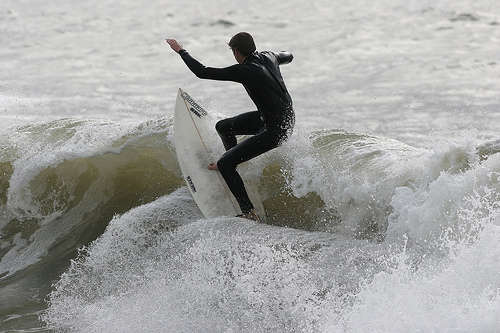

In [35]:
print (test_sample_captions[0])
IPython.display.Image(test_sample_filepaths[0])

a black dog is running on a field ENDOFSEQ


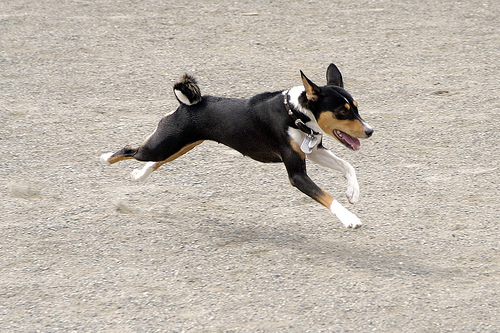

In [36]:
print (test_sample_captions[1])
IPython.display.Image(test_sample_filepaths[1])

a man is standing in the camera ENDOFSEQ


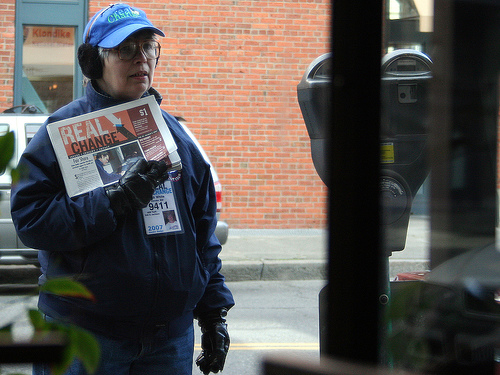

In [37]:
print (test_sample_captions[2])
IPython.display.Image(test_sample_filepaths[2])

a woman in a red shirt is standing in the street ENDOFSEQ


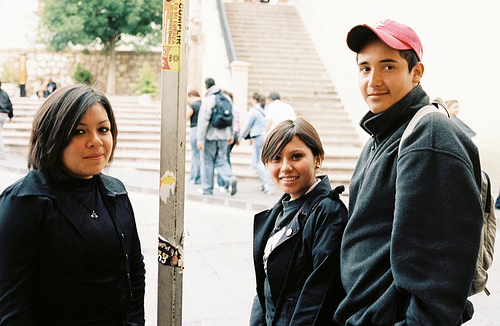

In [38]:
print (test_sample_captions[3])
IPython.display.Image(test_sample_filepaths[3])

a black dog is jumping on a black dog ENDOFSEQ


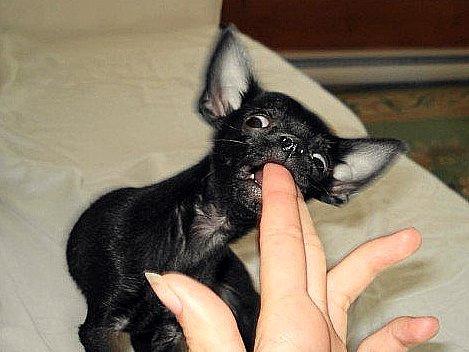

In [40]:
print (test_sample_captions[4])
IPython.display.Image(test_sample_filepaths[4])

Now calculating the **BLEU Score**

In [41]:
# test_images_filepath = '../input/flickr8k/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'
# with open(test_images_filepath, 'r') as test_images_file:
#     caption_list = ImageFilenameToTokenizedDescriptionsList(test_images_file)
#     test_images_list = [line.strip() for line in test_images_file]
# print ("len(test_images_list) = {}".format(len(test_images_list)))
# print(caption_list)

Generating caption for all of the test data

In [42]:
# Load the model that gave the lowest validation loss
lstm_model.load_state_dict(torch.load(best_model_filepath))
# Select all of the dataset
test_image_sample_indices = [i for i in range(1000)]
lstm_model.eval()
test_sample_filepaths = []
test_sample_captions = []
for test_image_sample_index in test_image_sample_indices:
    sample_words = TestSample(test_image_sample_index, test_images_list, image_filename_to_latent_variables, lstm_model,
       index_to_word_dict,
       word_to_embedding_dict,
       sequence_length=40,
       endOfSeqIndex=0,
       useCuda=useCuda) 
    caption = ' '.join(sample_words)
    test_sample_filepaths.append(os.path.join(imagesFilepath, test_images_list[test_image_sample_index]))
    test_sample_captions.append(caption)

In [43]:
#the list of predicted caption tokenized
#pre = [sub.split() for sub in test_sample_captions]
#remove startseq and endseq
stopwords = ['startseq','endofseq']
pre_new = [sub.split() for sub in test_sample_captions]

In [44]:
final_cap = []
for i in pre_new:
    i = [word for word in i if word.lower() not in stopwords]
    final_cap.append(i)

Now trying to make reference list

In [45]:
import pandas as pd
read_file = pd.read_csv(r'../input/annotated-test/annotatedtest.txt', sep = '\t')


In [46]:
read_file.head(5)

,image_id,captions
0,3385593926_d3e9c21170.jpg,<start> The dogs are in the snow in front of a...
1,3385593926_d3e9c21170.jpg,<start> The dogs play on the snow . <end>
2,3385593926_d3e9c21170.jpg,<start> Two brown dogs playfully fight in the ...
3,3385593926_d3e9c21170.jpg,<start> Two brown dogs wrestle in the snow . <...
4,3385593926_d3e9c21170.jpg,<start> Two dogs playing in the snow . <end>


In [47]:
#the list of predicted caption tokenized
#pre = [sub.split() for sub in test_sample_captions]
#remove startseq and endseq
from nltk.tokenize import word_tokenize
stopwords = ['<','start','>','end','.']
test_list = []
count = 1
small_list = []
    
for sen in read_file.captions:
        x = word_tokenize(sen)
        x = [word for word in x if word not in stopwords]
        #print(x)
        small_list.append(x)
        count += 1
        if(count > 5):
            test_list.append(small_list)
            small_list = []
            count = 1
    
    

In [48]:
from torchtext.data.metrics import bleu_score
# calculate BLEU score
candidate_corpus = final_cap
reference_corpus = test_list
bleu_score(candidate_corpus, reference_corpus)


0.11593033373355865

In [49]:
BLEU_1 = bleu_score(candidate_corpus, reference_corpus, max_n = 4, weights = [1,0,0,0])
BLEU_2 = bleu_score(candidate_corpus, reference_corpus, max_n = 4, weights = [0.5,0.5,0,0])
BLEU_3 = bleu_score(candidate_corpus, reference_corpus, max_n = 4, weights = [0.3,0.3,0.3,0])
BLEU_4 = bleu_score(candidate_corpus, reference_corpus, max_n = 4, weights = [0.25,0.25,0.25,0.25])
print("BLEU_1: {},\n BLEU_2: {},\n BLEU_3: {},\n BLEU_4: {}".format(BLEU_1,BLEU_2,BLEU_3,BLEU_4))

BLEU_1: 0.5565337538719177,
 BLEU_2: 0.3538365066051483,
 BLEU_3: 0.24337860941886902,
 BLEU_4: 0.11593033373355865


Summary of the model we used for LSTM

In [50]:
print(lstm_model)

LSTM_fixed_embedding(
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=1056, out_features=4430, bias=True)
)


In [51]:
sum([param.nelement() for param in lstm_model.parameters()])

4711694

In [52]:
print("Model structure: ",lstm_model, "\n\n")
for name, param in lstm_model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")

Model structure:  LSTM_fixed_embedding(
  (lstm): LSTM(128, 32, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=1056, out_features=4430, bias=True)
) 


Layer: lstm.weight_ih_l0 | Size: torch.Size([128, 128]) | Values: tensor([[ 8.5637e-02,  1.2639e-01,  2.0028e-01,  1.4295e-01, -5.3187e-02,
          2.7348e-01, -1.4748e-01,  2.1338e-01,  2.6976e-01, -8.2727e-02,
         -1.0093e-01,  1.6853e-01,  1.3808e-01, -8.4182e-02,  1.0688e-02,
         -2.1745e-01,  1.0457e-01,  8.0434e-02,  6.0397e-02, -2.0802e-01,
          4.8215e-02, -8.4479e-03, -1.6192e-01, -1.5354e-01, -2.4052e-01,
          2.9098e-01, -1.3562e-01, -3.0273e-01,  1.9692e-01, -1.3249e-01,
          1.3506e-01, -3.7522e-01,  2.3631e-01,  1.3513e-01, -3.8002e-02,
          8.7974e-02,  3.5021e-02, -1.7701e-01, -1.6947e-01, -9.7257e-02,
          3.5619e-01, -1.0969e-01,  4.4229e-02, -1.4964e-01, -1.4099e-01,
          1.8688e-01,  2.9253e-02,  2.4757e-01,  1.5885e-